In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/My\ Drive/CIS 581-Online/Canny Edge Project/Learner Code and Images/Code
sys.path.append('/content/drive/My Drive/CIS 581/Project 2/Learner Code and Images/Code')

# import functions
from edgeLink import edgeLink
import helpers

# Tests and Visualization

In [ ]:
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Test Passed! \n')
    else:
      print('Test Failed! \n')

    return test_pass

In [ ]:
'''
  Derivatives visualzation function
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))

    Ax3.imshow(I_gray, cmap='gray', interpolation='nearest')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    
    Q = plt.quiver(X, Y, Magx, Magy)
    qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')


'''
  Edge detection result visualization function
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

# Functions

In [ ]:
'''
  Convert RGB image to gray one manually
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [ ]:
def findDerivatives(I_gray):
    # TODO: implement
    # Gaussian filter definition
    G = np.array([[ 2,  4,  5,  4,  2], 
                  [ 4,  9, 12,  9,  4], 
                  [ 5, 12, 15, 12,  5], 
                  [ 4,  9, 12,  9,  4], 
                  [ 2,  4,  5,  4,  2]])
    G = G / 159

    # Filter for horizontal and vertical direction
    dx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    dy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Convolution of image with Gaussian
    Gx = signal.convolve2d(G, dx, mode='same')
    Gy = signal.convolve2d(G, dy, mode='same')

    # Convolution of image with Gx and Gy
    Magx = signal.convolve2d(I_gray, Gx, mode='same')
    Magy = signal.convolve2d(I_gray, Gy, mode='same')

    # Gradient magnitude and orientation
    Mag = np.sqrt(Magx * Magx + Magy * Magy)
    Ori = np.arctan2(Magy, Magx)

    return Mag, Magx, Magy, Ori

In [ ]:
def nonMaxSup(Mag, Ori):
    # TODO: implement
    # H x W matrix representing gradient magnitude
    H, W = Mag.shape[0], Mag.shape[1]
    M = np.zeros((H, W))

    # Gradient orientation with possible degrees of 
    # [0, 45, 90, 135, 180, -45, -90, -135, -180]
    grad_Ori = helpers.get_discrete_gradient_orientation(Ori)

    # Non-maximum suppression
    for i in range(1, H - 1):
        for j in range(1, W - 1):
            deg = grad_Ori[i, j]
            if (deg == 0) or (deg == 180) or (deg == -180):
                # 0 degree, 180 degree, or -180 degree
                compare1 = Mag[i, j - 1]
                compare2 = Mag[i, j + 1]
            elif (deg == 45) or (deg == -135):
                # 45 degree or -135 degree
                compare1 = Mag[i - 1, j + 1]
                compare2 = Mag[i + 1, j - 1]
            elif (deg == 90) or (deg == -90):
                # 90 degree or -90 degree
                compare1 = Mag[i - 1, j]
                compare2 = Mag[i + 1, j]
            elif (deg == 135) or (deg == -45):
                # 135 degree or -45 degree
                compare1 = Mag[i + 1, j + 1]
                compare2 = Mag[i - 1, j - 1]

            if (Mag[i, j] >= compare1) and (Mag[i, j] >= compare2):
                M[i, j] = 1

    return M

In [ ]:
def cannyEdge(I):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    edge_Ori = helpers.get_discrete_edge_orientation(Ori)
    E = edgeLink(M, Mag, edge_Ori)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)

        plt.show()

    return E

# Main

Test Passed! 



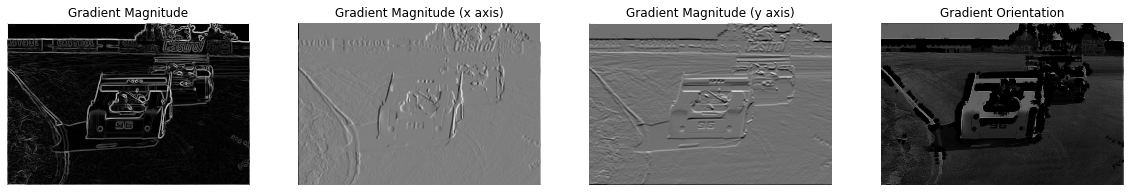

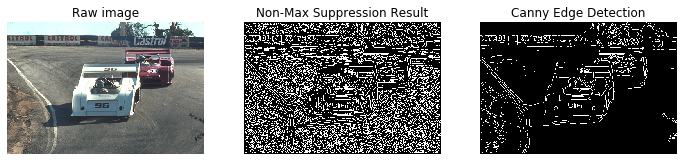

Test Passed! 



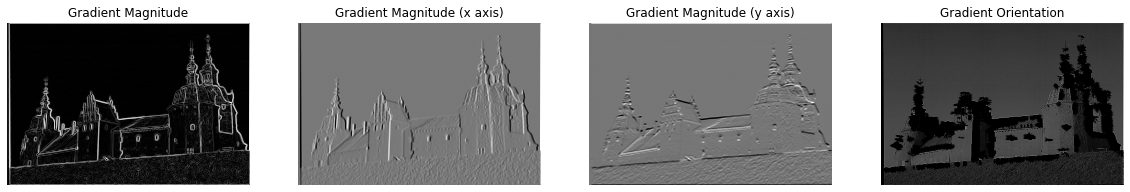

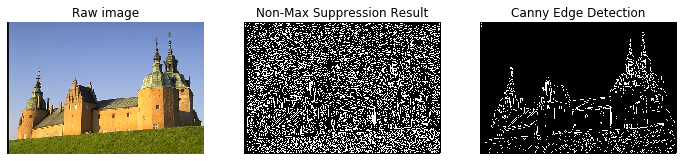

Test Passed! 



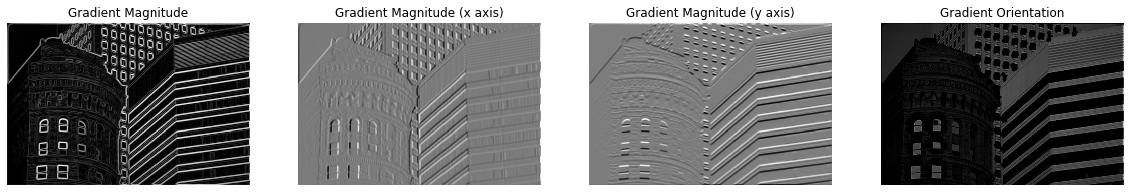

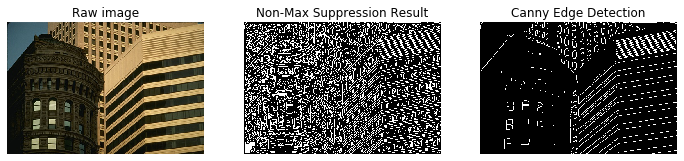

Test Passed! 



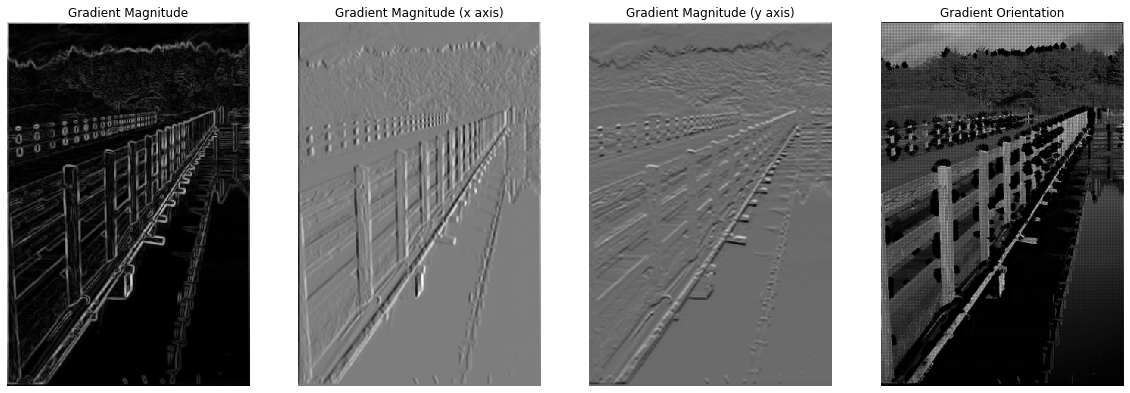

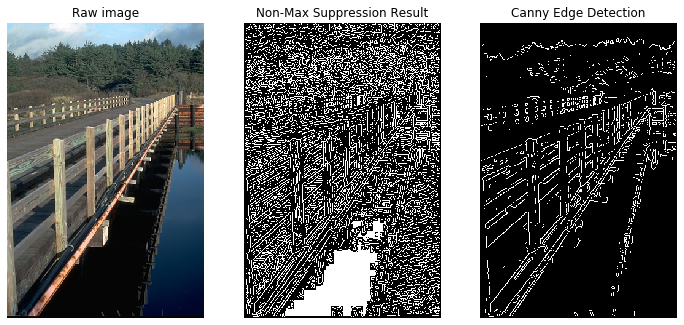

Test Passed! 



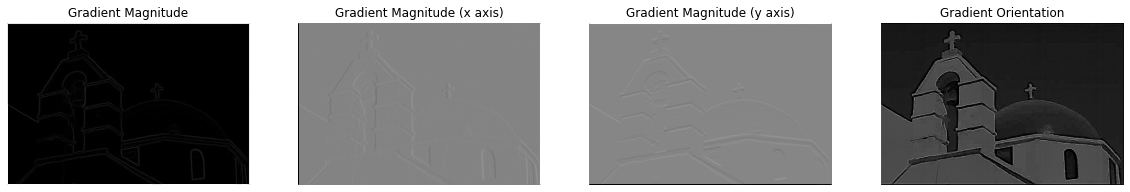

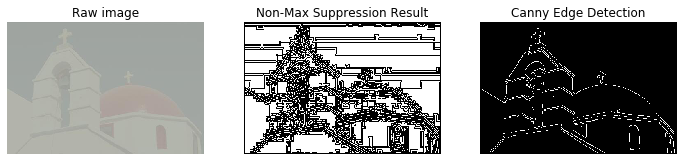

Test Passed! 



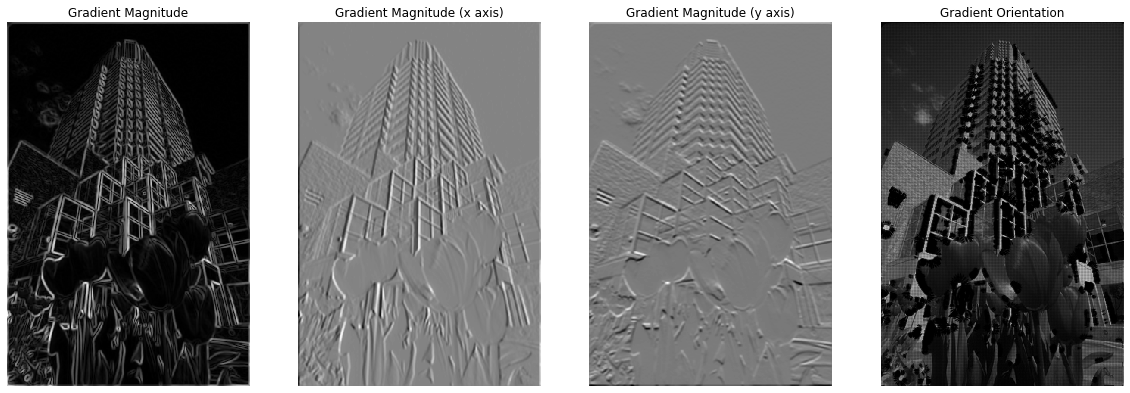

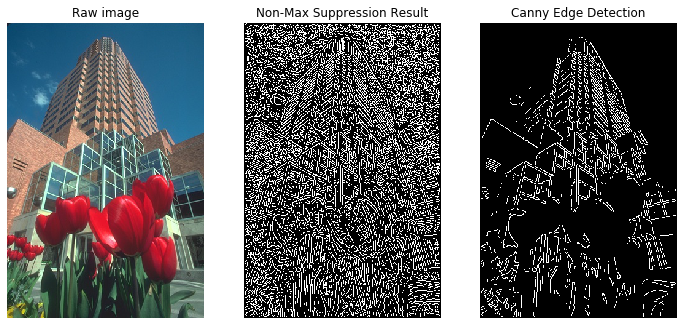

Test Passed! 



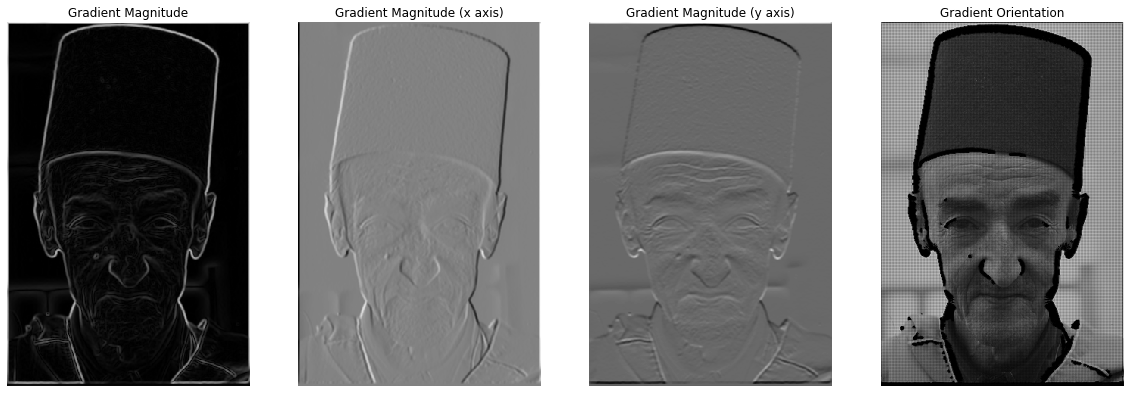

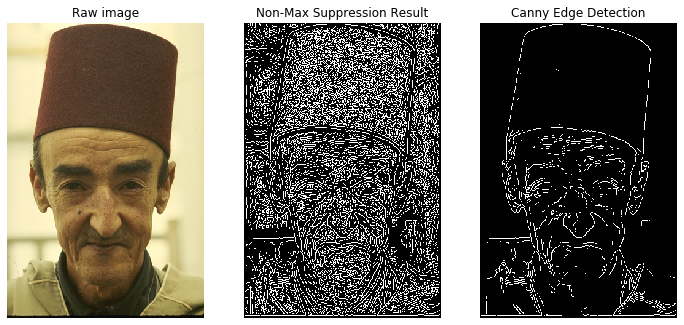

Test Passed! 



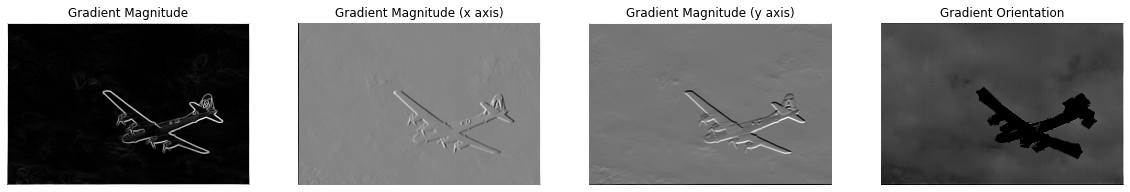

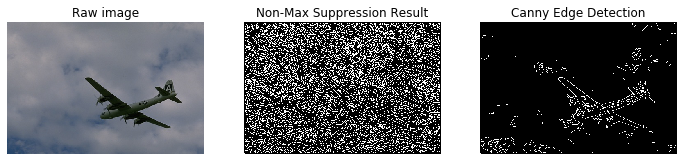

Test Passed! 



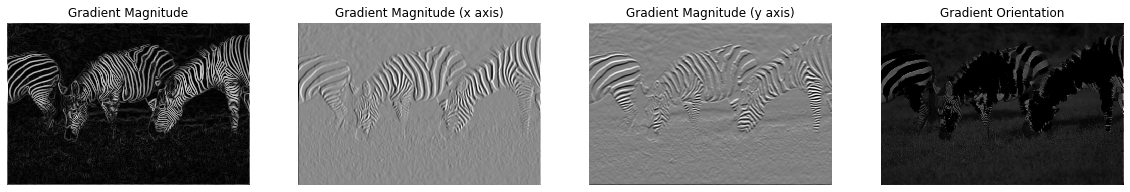

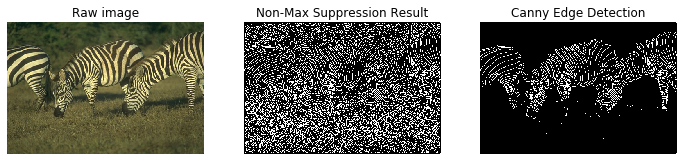

Test Passed! 



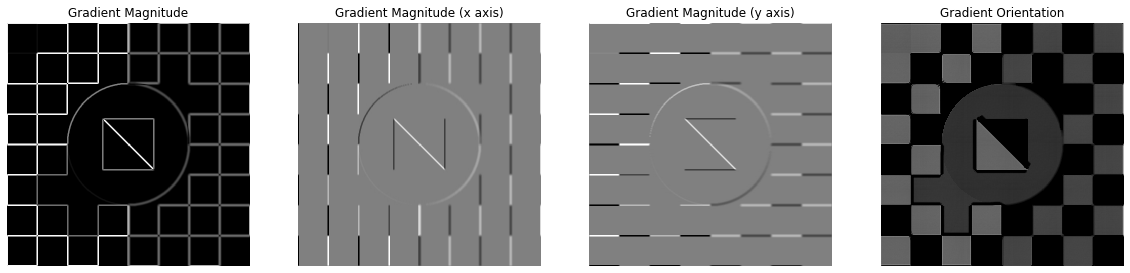

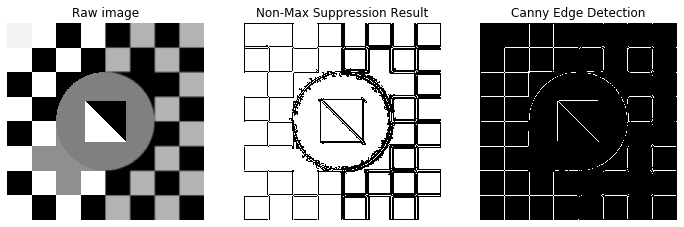

Test Passed! 



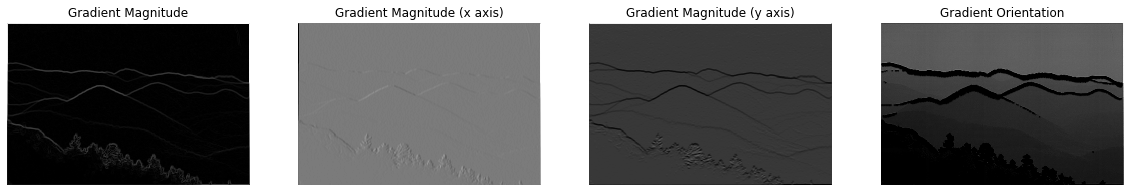

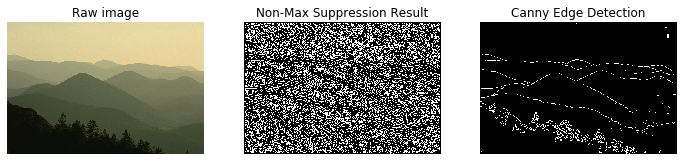

Test Passed! 



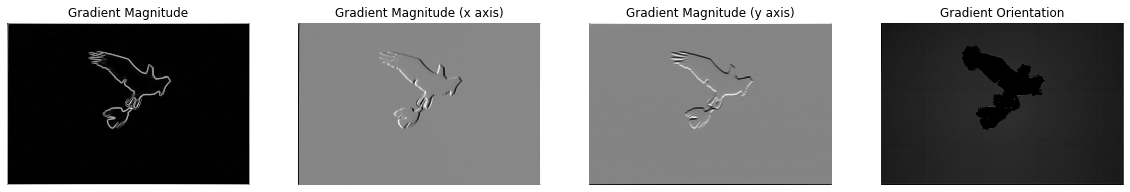

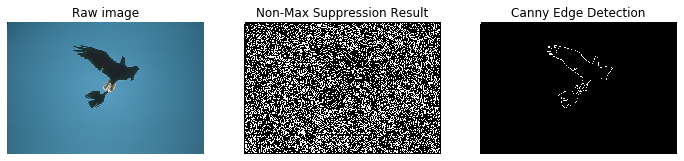

In [9]:
image_folder = "/content/drive/My Drive/CIS 581/Project 2/Learner Code and Images/Images"
save_folder = "/content/drive/My Drive/CIS 581/Project 2/Learner Code and Images/Results"

# read images one by one
for filename in os.listdir(image_folder):
    # read in image and convert color space for better visualization
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))

    ## TO DO: Complete 'cannyEdge' function
    E = cannyEdge(I)

    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))